## Model hyperparametr tuning

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import shap

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix

In [15]:
def score(X,y,name,alg):
    """_summary_

    Args:
        X (arraylike): dataset predictor variables
        y (arraylike): dataset label
        name (alghorithm name): name of the alghorithm
        alg (alghorithm object): trained alghorithm object

    Returns:
        DataFrame: dataframe with the alghorithm name, f1 score, precision score and recall score
    """
    scores =[]
    scores = [name , alg.score(X,y), recall_score(y,alg.predict(X)), precision_score(y,alg.predict(X)), f1_score(y,alg.predict(X)), roc_auc_score(y,alg.predict(X)), ]
    return scores


def RocCurveEstimators(X_test, y_test,alg):
    """_summary_

    Args:
        X_test (_type_): _description_
        y_test (_type_): _description_
        alg (_type_): _description_
    """
    for name , clf in alg:
        RocCurveDisplay.from_estimator(clf, X_test, y_test, name = name)
    plt.show()

#### Data preparation

In [6]:
data = pd.read_csv('data/telecom_churn.csv')
data.head(3)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2


In [8]:
ct = ColumnTransformer([
    ('binary data', OneHotEncoder(), [2,3]),
    ('standard', StandardScaler(), [1,4,5,6,7,8,9,10])],
    remainder = 'passthrough')

data =  ct.fit_transform(data)

In [39]:
data.shape

(3333, 13)

In [ ]:
data[:2]

array([[ 0.        ,  1.        ,  0.        ,  1.        ,  0.67648946,
         1.48020373, -0.42793202,  1.56676695,  0.47664315,  1.99072703,
        -0.0715836 , -0.08500823,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  1.        ,  0.14906505,
         2.26607248, -0.42793202, -0.33373776,  1.12450284,  1.56451025,
        -0.10708191,  1.24048169,  0.        ]])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(data).iloc[:,1:].values, pd.DataFrame(data)[0], test_size=0.2, random_state=2077)

In [43]:
x_train[:2]

array([[ 1.        ,  1.        ,  0.        , -1.13182282, -0.64164192,
        -0.42793202, -1.06823234, -0.81907622, -1.29723099, -0.70266478,
        -0.4790728 ,  0.        ],
       [ 1.        ,  1.        ,  0.        ,  0.1239496 , -0.3980226 ,
         0.33235445, -1.20044136,  0.17763099, -1.59558273, -2.41841676,
        -3.66741342,  0.        ]])

In [ ]:
x_train.shape

(2666, 12)

### Neural network

In [ ]:
param = {
    'hidden_layer_sizes' : [10,50,100,200,300],
    'activation' : [ 'tanh', 'relu'],
    'learning_rate_init' : [ 0.001, 0.01, 0.1, 1, ],
    'max_iter' : [ 400, 600,  1000],

}

In [ ]:
HPT_NN = GridSearchCV(MLPClassifier(),param, n_jobs = -1, verbose = 1)
HPT_NN.fit(x_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [10, 50, 100, 200, 300],
                         'learning_rate_init': [0.001, 0.01, 0.1, 1],
                         'max_iter': [400, 600, 1000]},
             verbose=1)

In [ ]:
best = HPT_NN.best_estimator_
HPT_NN.best_estimator_

MLPClassifier(activation='tanh', hidden_layer_sizes=10, max_iter=400)

In [ ]:
s = pickle.dump(HPT_NN, open('models/NN_tuned.pkl', 'wb'))

### XGBoost

In [ ]:
param = {
    'n_estimators' : [100, 200, 300,600, 800],
    'max_depth' : [3,  5, 6, 7,  9],
}

In [ ]:
HPT_XGB = GridSearchCV(XGBClassifier(),param, n_jobs = -1, verbose = 1,error_score='raise')
HPT_XGB.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_...,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 9],
                         'n_estimators': [100, 200, 300, 600, 800]},
             verbose=1)

In [ ]:
best = HPT_XGB.best_estimator_
HPT_XGB.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
s = pickle.dump(HPT_XGB, open('models/XGB_tuned.pkl', 'wb'))

### XGBoost- early stopping

In [ ]:
x_test,x_val,y_test, y_val = train_test_split(x_test,y_test, test_size=0.3)

In [ ]:
param = {
    'n_estimators' : [100, 200, ],
    'max_depth' : [3,  5, 6, ],
}
fit_params = {
    "early_stopping_rounds" : 42,
    "eval_metric" : "mae", 
    "eval_set" : [[x_val, y_val]]
}

In [ ]:
HPT_XGB = GridSearchCV(XGBClassifier(),param, n_jobs = -1, verbose = 1,error_score='raise')
HPT_XGB.fit(x_train, y_train, **fit_params)

In [ ]:
s = pickle.dump(HPT_XGB, open('models/XGB_earlystopping_tuned.pkl', 'wb'))

## Model evaluation

### Metrics

In [25]:
nn = pickle.load(open('models/NN_tuned.pkl', 'rb'))
xgb = pickle.load(open('models/XGB_tuned.pkl', 'rb'))

In [26]:
xgb_score = score(x_test,y_test,'NN',xgb)
xgb_score

['NN', 1.0, 1.0, 1.0, 1.0, 1.0]

In [19]:
nn_score = score(x_test,y_test,'NN',nn)
nn_score

['NN', 1.0, 1.0, 1.0, 1.0, 1.0]

### Confusion Matrix

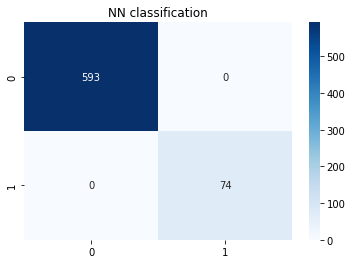

In [22]:
plt.title('NN classification')
sns.heatmap(confusion_matrix(y_test, nn.predict(x_test)), annot=True, fmt='d', cmap='Blues')
plt.show()

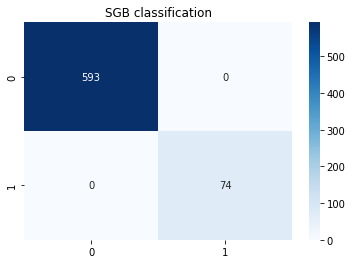

In [27]:
plt.title('XGB classification')
sns.heatmap(confusion_matrix(y_test, xgb.predict(x_test)), annot=True, fmt='d', cmap='Blues')
plt.show()

### XGB feature importance

In [44]:
xgb.best_estimator_.feature_importances_

array([9.9998558e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.4441814e-05, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

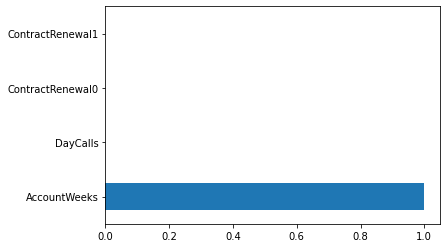

In [46]:
pd.Series( xgb.best_estimator_.feature_importances_, index=
['AccountWeeks',	'ContractRenewal0','ContractRenewal1',	'DataPlan0','DataPlan1',	'DataUsage',	'CustServCalls',	'DayMins',	'DayCalls',	'MonthlyCharge',	'OverageFee',	'RoamMins']).nlargest(4).plot(kind='barh');

### SHAP Values

In [ ]:
shap.explainers.Sampling(nn.best_estimator_, x_train, nsamples=1000)

In [55]:
sample = shap.sample(x_test, 100)

Using 2666 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

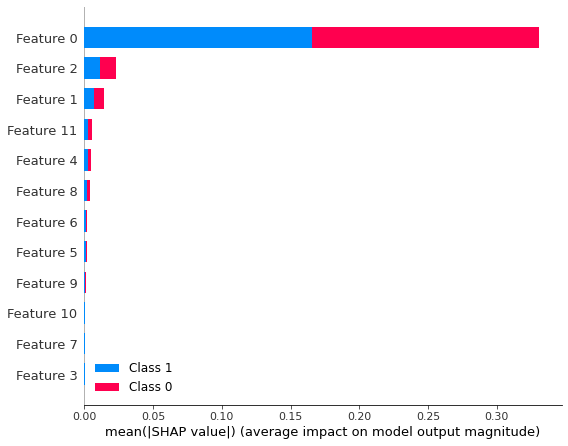

In [57]:
s =shap.KernelExplainer(nn.predict_proba, x_train).shap_values(sample)
shap.summary_plot(s, sample, plot_type="bar")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


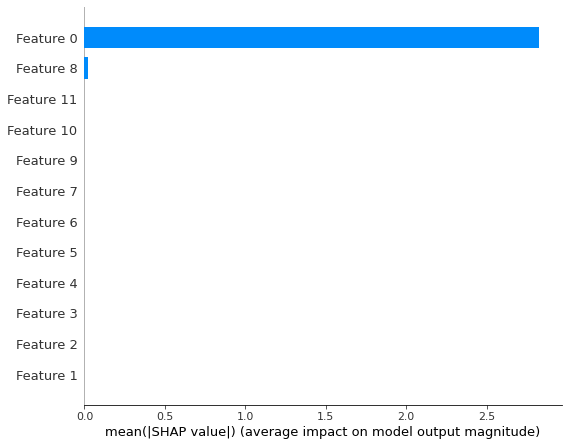

In [58]:
s =shap.TreeExplainer(xgb.best_estimator_).shap_values(x_test)
shap.summary_plot(s, x_test, plot_type="bar")

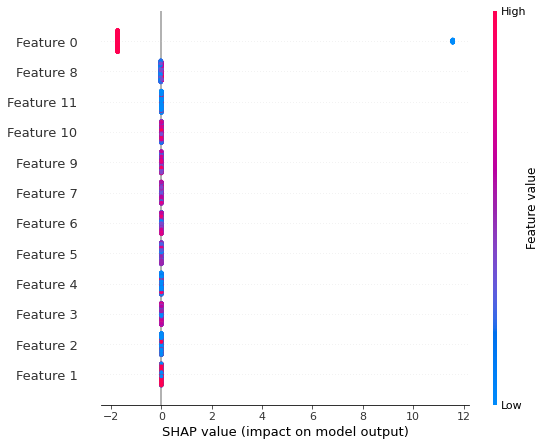

In [59]:
shap.summary_plot(s, x_test)

Feature 0 is an AccountWeeks variable

Hyperparamter tuning led to overfitting both models. XBGBoost model most likely overfits because it rembemberd AccountWeeks value for each customer.

### Dalex - model agnostic explainer

In [2]:
import dalex as dx

In [9]:
X, y = pd.DataFrame(data).iloc[:,1:].values,  pd.DataFrame(data)[0]
exp = dx.Explainer(xgb, X, y)

Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns are set as string numbers.
  -> data              : 3333 rows 12 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3333 values
  -> model_class       : sklearn.model_selection._search.GridSearchCV (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000024B56149B80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000403, mean = 0.0969, max = 0.996
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.000424, mean = 1.56e-05, max = 0.00412
  -> model_info        : package sklearn

A new explainer has been create

In [11]:
exp.model_diagnostics()

,0,1,2,3,4,5,6,7,8,9,10,11,y,y_hat,residuals,abs_residuals,label,ids
0,1.0,0.0,1.0,0.676489,1.480204,-0.427932,1.566767,0.476643,1.990727,-0.071584,-0.085008,0.0,0.0,0.000424,-0.000424,0.000424,GridSearchCV,1
1,1.0,0.0,1.0,0.149065,2.266072,-0.427932,-0.333738,1.124503,1.564510,-0.107082,1.240482,0.0,0.0,0.000424,-0.000424,0.000424,GridSearchCV,2
2,1.0,1.0,0.0,0.902529,-0.641642,-1.188218,1.168304,0.675985,-0.262133,-1.574346,0.703121,0.0,0.0,0.000403,-0.000403,0.000403,GridSearchCV,3
3,0.0,1.0,0.0,-0.428590,-0.641642,0.332354,2.196596,-1.466936,0.042307,-2.741846,-1.303026,0.0,1.0,0.996082,0.003918,0.003918,GridSearchCV,4
4,0.0,1.0,0.0,-0.654629,-0.641642,1.092641,-0.240090,0.626149,-0.931902,-1.037927,-0.049184,0.0,1.0,0.995884,0.004116,0.004116,GridSearchCV,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,1.0,0.0,1.0,2.283878,1.456628,0.332354,-0.432895,-1.167924,0.937363,0.287344,-0.120832,0.0,0.0,0.000424,-0.000424,0.000424,GridSearchCV,3329
3329,1.0,1.0,0.0,-0.830437,-0.374447,1.092641,0.942447,-2.164631,0.005775,-0.939320,-0.228304,0.0,0.0,0.000424,-0.000424,0.000424,GridSearchCV,3330
3330,1.0,1.0,0.0,-1.835055,-0.641642,0.332354,0.018820,0.426808,-0.018581,1.730942,1.383778,0.0,0.0,0.000424,-0.000424,0.000424,GridSearchCV,3331
3331,0.0,1.0,0.0,2.082955,-0.641642,0.332354,0.624778,0.227466,-0.383909,-0.817048,-1.876211,0.0,1.0,0.995884,0.004116,0.004116,GridSearchCV,3332


In [13]:
exp.model_fairness()

TypeError: model_fairness() missing 2 required positional arguments: 'protected' and 'privileged'

In [12]:
exp.model_parts()

,variable,dropout_loss,label
0,1,0.000000,GridSearchCV
1,10,0.000000,GridSearchCV
2,11,0.000000,GridSearchCV
3,2,0.000000,GridSearchCV
4,3,0.000000,GridSearchCV
5,4,0.000000,GridSearchCV
6,5,0.000000,GridSearchCV
7,6,0.000000,GridSearchCV
8,7,0.000000,GridSearchCV
9,8,0.000000,GridSearchCV


## Ensemble model

In [ ]:
from sklearn.ensemble import VotingClassifier